# SARIMA Modelling

In this notebook, a dataset containing Leaf Area Index data will be examined and differenced before using it to build a SARIMA model. Grid search will be used to find the most ideal model, and the best model will then be evaluated and used to predict the Leaf Area Index from 2014 to 2018.

## Import libraries and data

In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import math
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('/Users/andrea/anaconda3/Notebooks/FDP/New Area/final_LAI.csv', index_col = 0)
df

,Date,LAI
0,2000-01-31,6.54
1,2000-02-28,6.39
2,2000-03-31,4.19
3,2000-04-30,5.40
4,2000-05-31,5.95
...,...,...
199,2016-08-31,6.09
200,2016-09-30,6.42
201,2016-10-31,6.39
202,2016-11-30,4.66


## Visualise dataframe

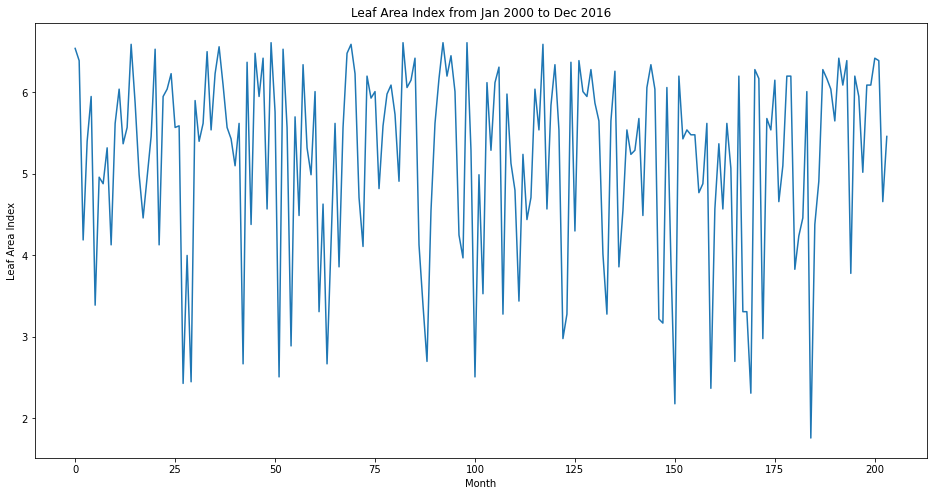

In [3]:
plt.figure(figsize=[16, 8]) # Set dimensions for figure
plt.plot( df['LAI'])
plt.title('Leaf Area Index from Jan 2000 to Dec 2016')
plt.ylabel('Leaf Area Index')
plt.xlabel('Month')
plt.show()

## Stationarity 

In many cases, the data passed to a SARIMA model should be stationarity. There is no obvious trend in the data, but the constant rise and fall could point to seasonality. The stationarity will be checked by plotting ACF, PACF and Dickey-Fuller test.

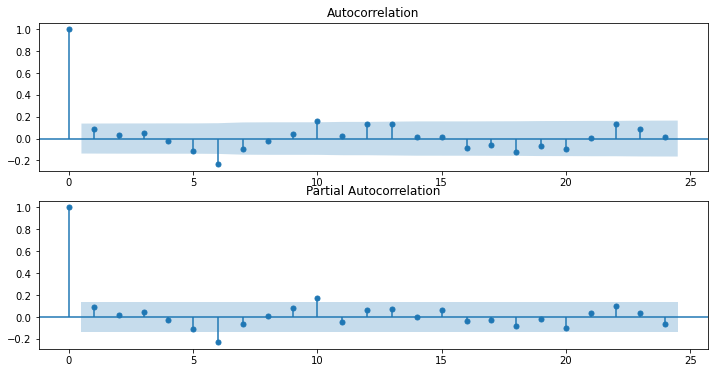

In [4]:
fig,ax = plt.subplots(2,1,figsize=(12,6))
fig = sm.graphics.tsa.plot_acf(df['LAI'], ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df['LAI'], ax=ax[1])
plt.show()

In [5]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(df['LAI'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
print(f'Critical Values: {ad_fuller_result[4]}')

ADF Statistic: -7.527619138486342
p-value: 3.64928439894758e-11
Critical Values: {'1%': -3.4638151713286316, '5%': -2.876250632135043, '10%': -2.574611347821651}


The ACF and PACF output show no clear signs of non-stationarity. One can see a significant negative spike at lag 6, but other than that, the data seems to follow a sinusoidal shape. The Dickey-Fuller test shows a very low p-value. In this test, the null hypothesis is that the data is non-stationary, and only if the p-value is below 0.05%, can we reject the null hypothesis and say that the data is stationary.

## Seasonal Decompose

<Figure size 432x288 with 0 Axes>

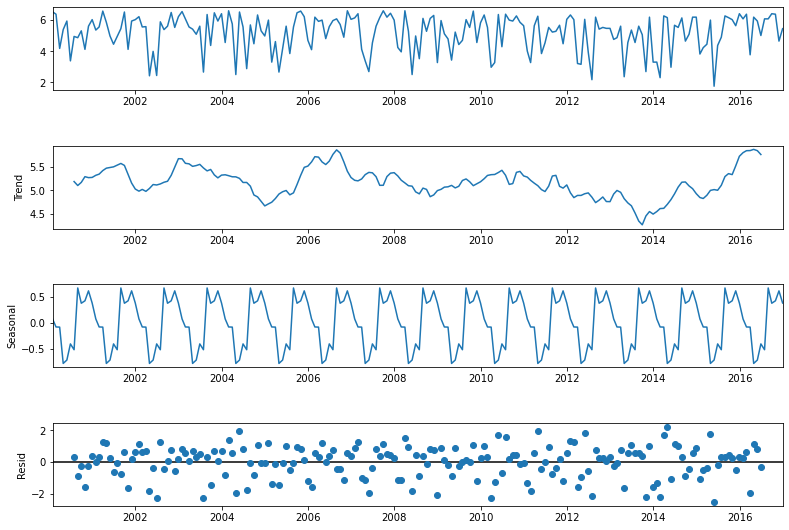

In [6]:
dec_df = df.copy()
dec_df['Date'] = pd.to_datetime(dec_df.Date) 
dec_df.set_index('Date',inplace = True)
decompose  = seasonal_decompose(dec_df.resample('M').sum(),freq=12)
fig = plt.figure()
fig = decompose.plot()
fig.set_size_inches(12,8)

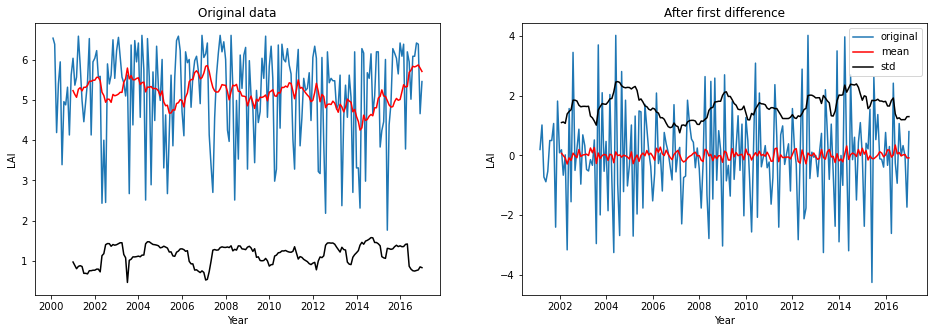

In [7]:
df_diff = dec_df.resample('M').sum()
df_diff['Diff1'] = df_diff['LAI'].diff() # first difference 
df_diff.dropna(inplace =True)

df_diff['Seasonal'] = df_diff['Diff1'].diff(12) # seasonal difference 
df_diff.dropna(inplace =True)

# plot of time series data for ADF test
fig ,ax = plt.subplots(1,2,figsize=(16,5))
# mean, std of original data 
mean1 = dec_df['LAI'].rolling(12).mean()
std1 = dec_df['LAI'].rolling(12).std()
ax[0].plot(dec_df['LAI'],label = 'original')
ax[0].plot(mean1,color ='red',label = 'mean')
ax[0].plot(std1,color ='black',label = 'std')
ax[0].set_title("Original data")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("LAI")
# mean, std after first difference data 
mean2 = df_diff['Diff1'].rolling(12).mean()
std2 = df_diff['Diff1'].rolling(12).std()
ax[1].plot(df_diff['Diff1'],label = 'original')
ax[1].plot(mean2,color ='red',label = 'mean')
ax[1].plot(std2,color ='black',label = 'std')
ax[1].set_title("After first difference")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("LAI")
plt.legend(loc ='best')
plt.show()

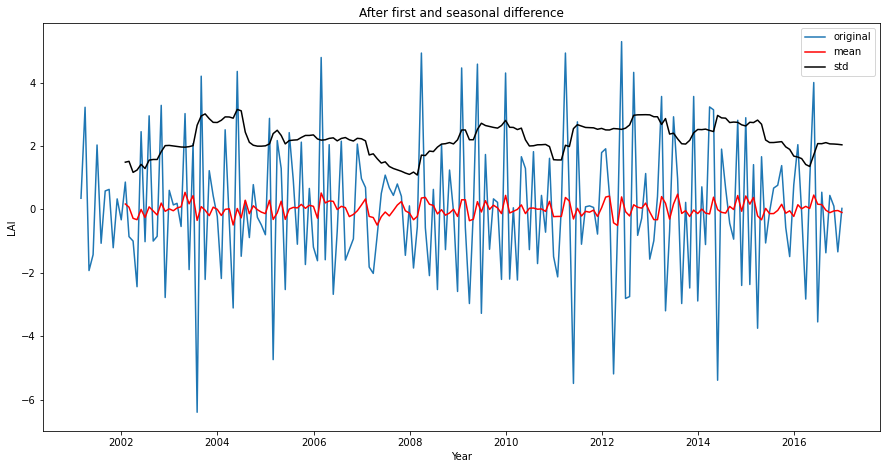

In [8]:
# mean, std  after seasonal difference data 
plt.figure(figsize=[15, 7.5])
mean3 = df_diff['Seasonal'].rolling(12).mean()
std3 = df_diff['Seasonal'].rolling(12).std()
plt.plot(df_diff['Seasonal'],label = 'original')
plt.plot(mean3,color ='red',label = 'mean')
plt.plot(std3,color ='black',label = 'std')
plt.title("After first and seasonal difference")
plt.ylabel('LAI')
plt.xlabel('Year')
plt.legend(loc ='best')
plt.show()

## Difference the data

In [9]:
# Log difference
df['LAI'] = np.log(df['LAI'])
df['LAI'] = df['LAI'].diff()

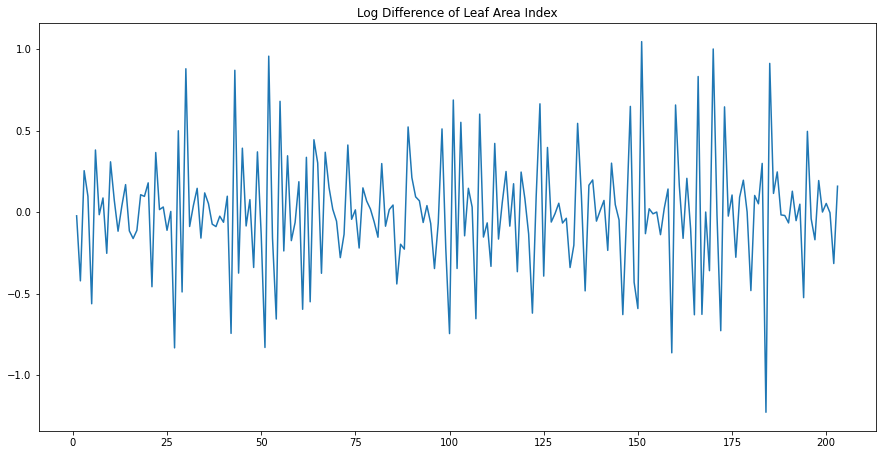

In [10]:
plt.figure(figsize=[15, 7.5])
plt.plot(df['LAI'])
plt.title("Log Difference of Leaf Area Index")
plt.show()

In [11]:
# Seasonal differencing
df['LAI'] = df['LAI'].diff(12)

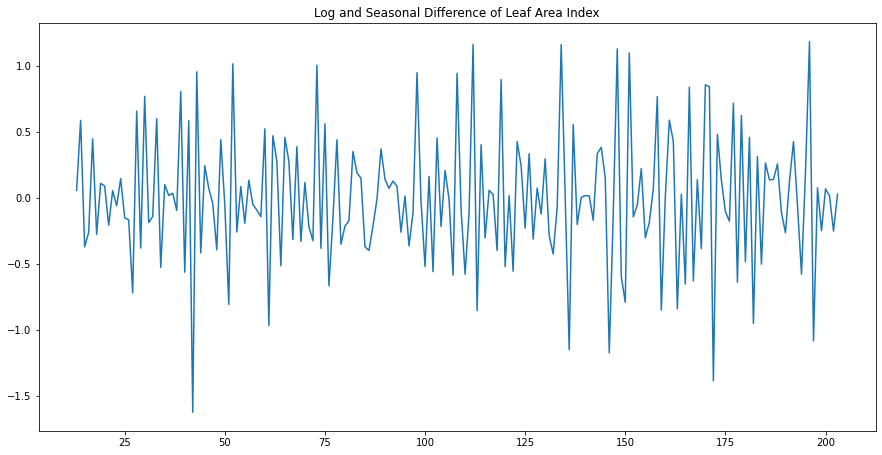

In [12]:
plt.figure(figsize=[15, 7.5])
plt.plot(df['LAI'])
plt.title('Log and Seasonal Difference of Leaf Area Index')
plt.show()

In [13]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(df['LAI'][13:])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
print(f'Critical Values: {ad_fuller_result[4]}')

ADF Statistic: -7.284125689047103
p-value: 1.4740203975840173e-10
Critical Values: {'1%': -3.4682803641749267, '5%': -2.8782017240816327, '10%': -2.5756525795918366}


## Split data into train and test set

In [14]:
train = df[0:(len(df) - 36)]

## Build SARIMA Model using Grid Search

In [15]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [16]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 12
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [17]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 12, train['LAI'][13:])
result_df

,"(p,q)x(P,Q)",AIC
0,"(0, 3, 2, 3)",127.142698
1,"(1, 2, 2, 3)",128.240504
2,"(0, 2, 0, 2)",128.296095
3,"(0, 2, 1, 3)",128.548512
4,"(0, 2, 2, 3)",128.735313
...,...,...
251,"(2, 0, 0, 0)",402.588183
252,"(0, 0, 2, 0)",406.668103
253,"(1, 0, 0, 0)",439.350965
254,"(0, 0, 1, 0)",439.884700


In [18]:
best_model = SARIMAX(train['LAI'][13:], order=(0, 1, 3), seasonal_order=(2, 1, 3, 12)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                LAI   No. Observations:                  155
Model:             SARIMAX(0, 1, 3)x(2, 1, 3, 12)   Log Likelihood                 -54.571
Date:                            Tue, 18 May 2021   AIC                            127.143
Time:                                    14:15:13   BIC                            153.745
Sample:                                         0   HQIC                           137.953
                                            - 155                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.1369      0.550     -3.887      0.000      -3.214      -1.059
ma.L2          1.2869      0.670   

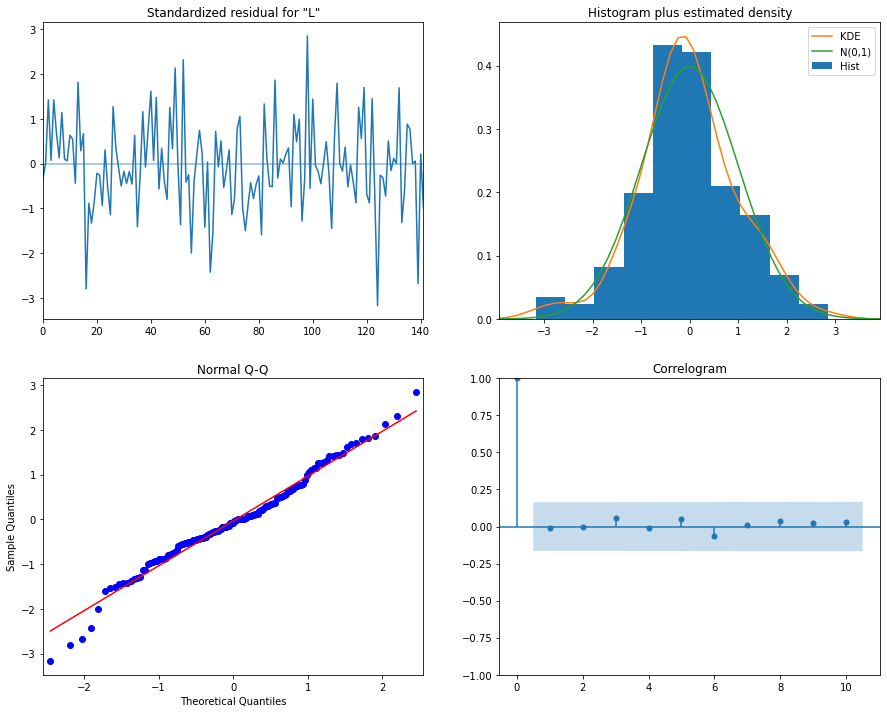

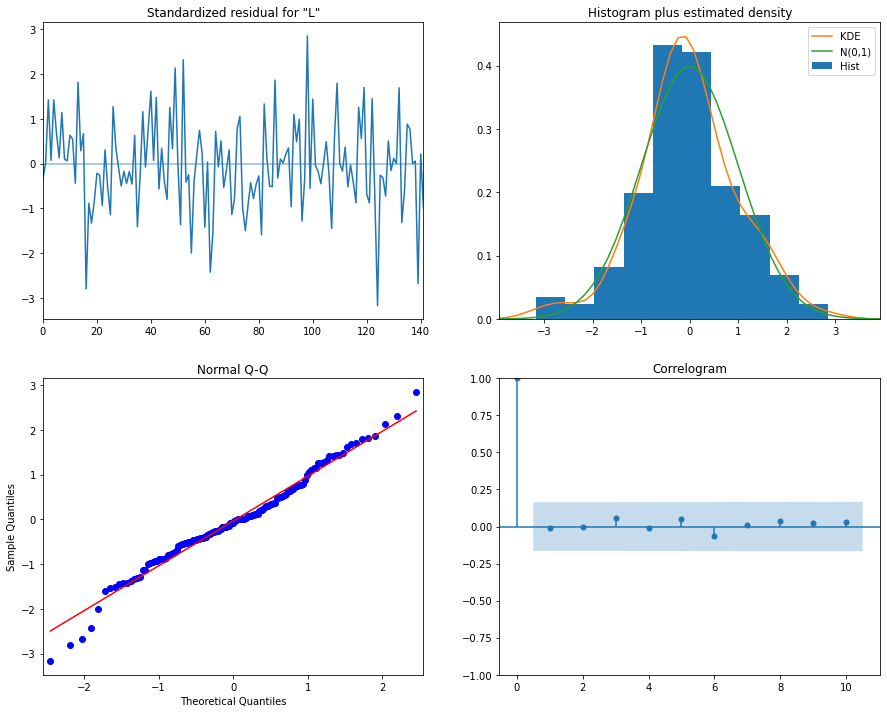

In [19]:
# Display diagnostics
best_model.plot_diagnostics(figsize=(15,12))

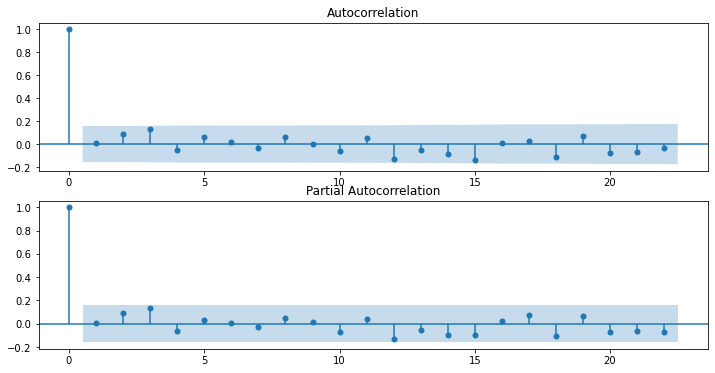

In [20]:
# Display ACF and PACF of residuals
res = best_model.resid
fig,ax = plt.subplots(2,1,figsize=(12,6))
fig = sm.graphics.tsa.plot_acf(res, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, ax=ax[1])
plt.show()

## Visualise prediction and actual data

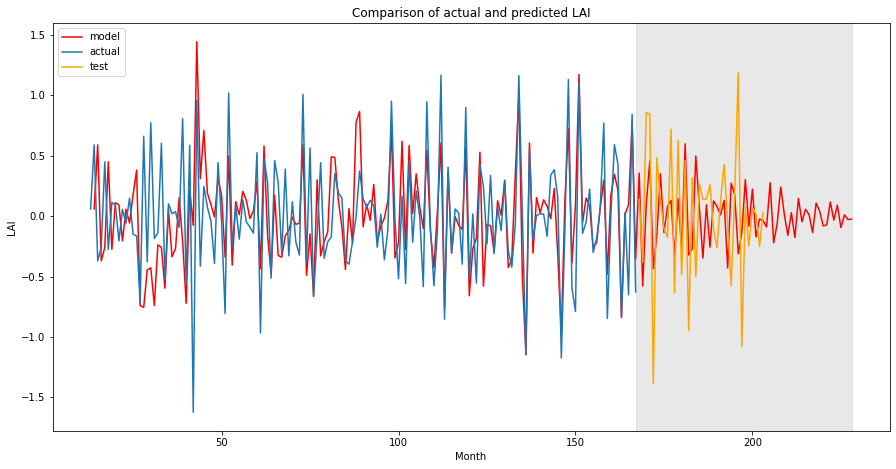

In [21]:
train['sarima_model'] = best_model.fittedvalues
train['sarima_model'][:13+1] = np.NaN
forecast = best_model.predict(start=train.shape[0], end=(train.shape[0] + 60))
forecast = train['sarima_model'].append(forecast)
test36 = df['LAI'][168:204]
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(train.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(train['LAI'][13:], label='actual')
plt.plot(test36, color='orange', label='test')
plt.title('Comparison of actual and predicted LAI')
plt.ylabel('LAI')
plt.xlabel('Month')
plt.legend()
plt.show()

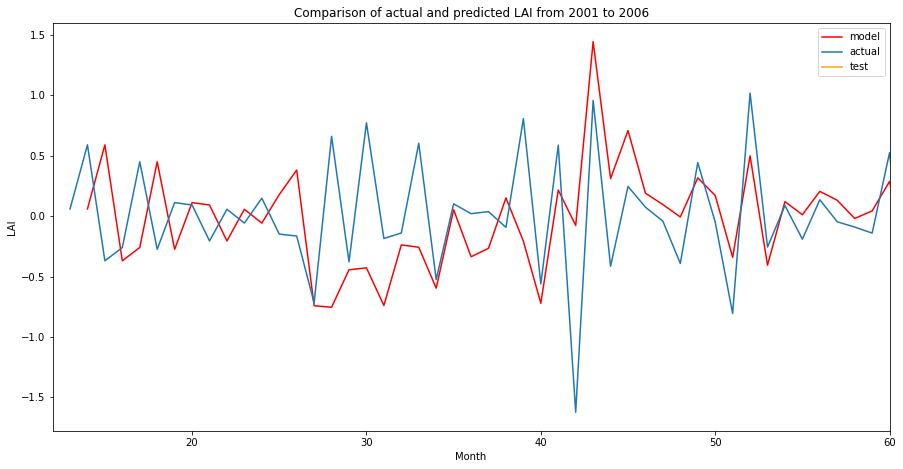

In [73]:
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(df.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(train['LAI'][13:], label='actual')
plt.plot(test36, color='orange', label='test')
plt.xlim([12, 60])
plt.title('Comparison of actual and predicted LAI from 2001 to 2006')
plt.ylabel('LAI')
plt.xlabel('Month')
plt.legend()
plt.show()

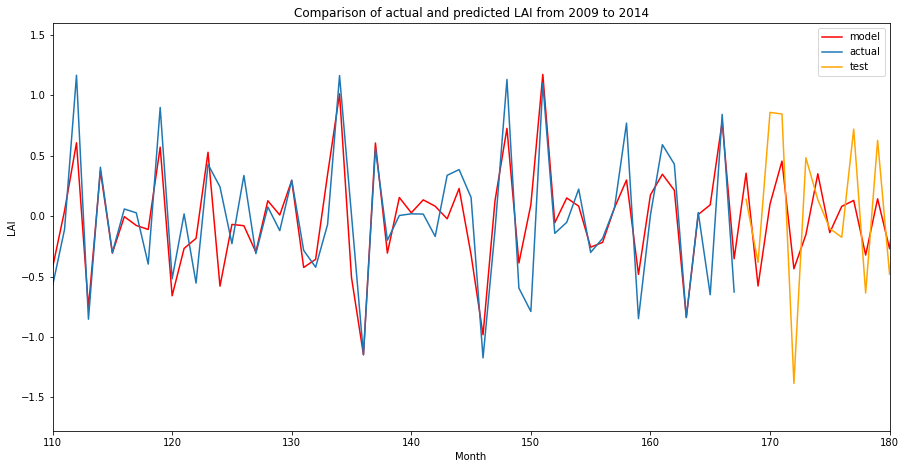

In [75]:
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(df.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(train['LAI'][13:], label='actual')
plt.plot(test36, color='orange', label='test')
plt.xlim([110, 180])
plt.title('Comparison of actual and predicted LAI from 2009 to 2014')
plt.ylabel('LAI')
plt.xlabel('Month')
plt.legend()
plt.show()

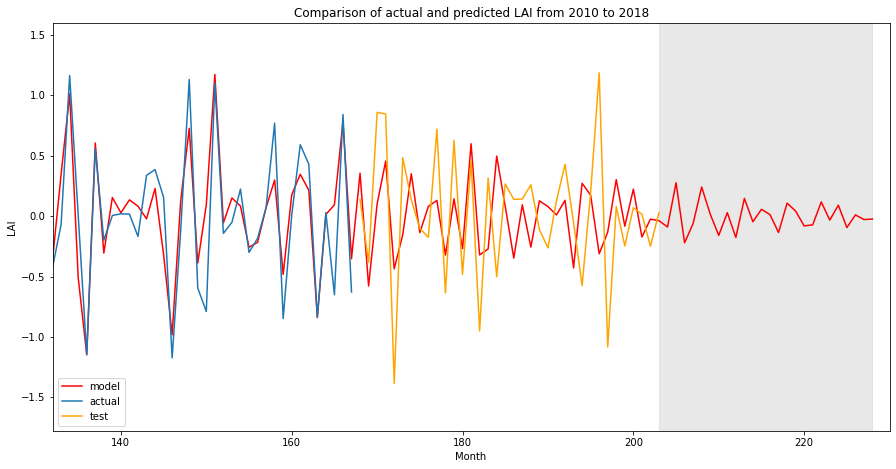

In [23]:
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(df.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(train['LAI'][13:], label='actual')
plt.plot(test36, color='orange', label='test')
plt.xlim([132, 230])
plt.title('Comparison of actual and predicted LAI from 2010 to 2018')
plt.ylabel('LAI')
plt.xlabel('Month')
plt.legend()
plt.show()

## Calculate error metrics

In [24]:
def unlog_pred(log_pred):
    
    pred = [i for i in log_pred.values]
    pred = pd.Series(pred, index = log_pred.index)
    
    return pred

pred_forecast_log = best_model.get_forecast(steps = 49)
pred_forecast = unlog_pred(pred_forecast_log.predicted_mean)

In [25]:
# compute mean squared error
fcast = pred_forecast[13:].values
true = test36.values

mse_score = ((fcast - true) ** 2).mean()
print('MSE of our forecasts is {}'.format(round(mse_score, 3)))

MSE of our forecasts is 0.27


In [26]:
# compute root mean squared error
rmse = math.sqrt(mse_score)
rmse

0.5197615466269561

In [27]:
# compute mean absolute percentage error
mape = (abs(fcast-true)/true)*100
mape.mean()

46.43210319270586

In [28]:
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = best_model.test_normality('jarquebera')[0]
lb_val, lb_p = best_model.test_serial_correlation(method='ljungbox')[0]
het_val, het_p = best_model.test_heteroskedasticity('breakvar')[0]

# Ljung-Box test
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(best_model.filter_results.standardized_forecasts_error[0, best_model.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Normality: val=3.487, p=0.175
Ljung-Box: val=9.247, p=0.997
Heteroskedasticity: val=1.473, p=0.188
Durbin-Watson: d=2.01


## Compare true and predicted values

In [39]:
comparison_df = pd.DataFrame(list(zip(true, fcast)),
               columns =['True', 'Forecast'])

In [65]:
# compute difference between true and predicted values
def get_change(current, previous):
    if current == previous:
        return 0
    try:
        return (float((current) - (previous)) / previous) * 100.0
    except ZeroDivisionError:
        return float('inf')

In [76]:
diff_list = []
for f,t in zip(comparison_df['Forecast'].values, comparison_df['True'].values):
    d = get_change(f,t) #forecasted - true values
    r = round(d, 1)
    diff_list.append(r)

In [78]:
comparison_df['Percentage Difference'] = diff_list

In [106]:
comparison_df.head()

,True,Forecast,Difference,Percentage Difference
0,0.138759,0.355546,-0.216787,156.2
1,-0.382500,-0.578001,0.195502,51.1
2,0.858936,0.100252,0.758684,-88.3
3,0.845771,0.455781,0.389989,-46.1
4,-1.384399,-0.435629,-0.948770,-68.5


In [80]:
# Transpose df for better in-report fit
com_df_T = comparison_df.T

In [92]:
com_df_T.iloc[:,0:18]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
True,0.138759,-0.382500,0.858936,0.845771,-1.384399,0.483713,0.136358,-0.102361,-0.174446,0.720314,-0.635989,0.627601,-0.481684,0.461399,-0.949537,0.315947,-0.500335,0.266707
Forecast,0.355546,-0.578001,0.100252,0.455781,-0.435629,-0.153681,0.351099,-0.136186,0.081049,0.130424,-0.321637,0.143832,-0.269197,0.599201,-0.321092,-0.270594,0.497574,0.081119
Difference,-0.216787,0.195502,0.758684,0.389989,-0.948770,0.637394,-0.214741,0.033826,-0.255495,0.589890,-0.314351,0.483769,-0.212487,-0.137802,-0.628445,0.586541,-0.997909,0.185588
Percentage Difference,156.200000,51.100000,-88.300000,-46.100000,-68.500000,-131.800000,157.500000,33.000000,-146.500000,-81.900000,-49.400000,-77.100000,-44.100000,29.900000,-66.200000,-185.600000,-199.400000,-69.600000


In [93]:
com_df_T.iloc[:,18:36]

,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
True,0.139182,0.141638,0.259765,-0.111520,-0.262057,0.127763,0.428914,-0.053612,-0.575596,0.196549,1.186953,-1.081696,0.078993,-0.246096,0.070441,0.016611,-0.248970,0.030671
Forecast,-0.346988,0.093764,-0.256219,0.127023,0.079755,0.010566,0.131112,-0.428118,0.272267,0.173736,-0.311489,-0.131720,0.302548,-0.082979,0.224074,-0.172349,-0.024409,-0.037094
Difference,0.486170,0.047875,0.515984,-0.238543,-0.341812,0.117197,0.297802,0.374506,-0.847863,0.022814,1.498442,-0.949976,-0.223555,-0.163117,-0.153633,0.188960,-0.224562,0.067765
Percentage Difference,-349.300000,-33.800000,-198.600000,-213.900000,-130.400000,-91.700000,-69.400000,698.500000,-147.300000,-11.600000,-126.200000,-87.800000,283.000000,-66.300000,218.100000,-1137.600000,-90.200000,-220.900000


In [96]:
# compute average of percentage mean
percentage_mean = comparison_df['Percentage Difference'].mean()
percentage_mean

-72.28333333333335

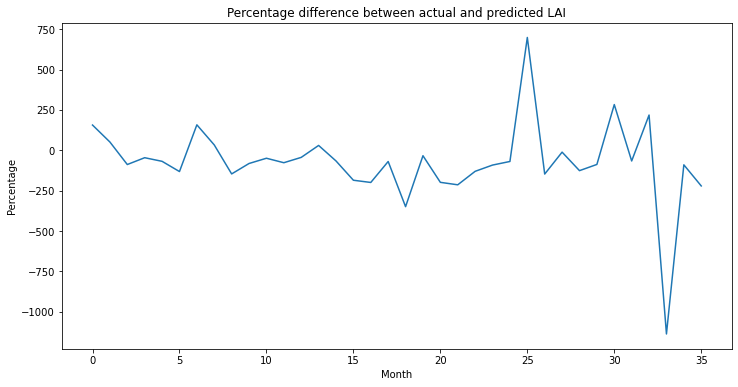

In [105]:
# visualise percentage change from 2014 to 2016
plt.figure(figsize=[12, 6])
plt.plot(comparison_df['Percentage Difference'])
plt.title('Percentage difference between actual and predicted LAI')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.show()